Reducing neural network information content
--

This demo shows how to reduce neural network information content during the neural network training session. The method defines a regularization that pushes the networks weights to a few selected values.

We begin by importing the tensorflow neural network library and a dataset for testing

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
from itertools import chain
from math import sqrt, pi, log

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


We start by defining a few helper-functions for network creation.

In [16]:
def weight_variable(shape, name=None):
    name = name.replace(" ", "_")
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name=None):
    name = name.replace(" ", "_")
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

We initialize a fairly basic convolution network that is commonly seen used on the mnist dataset.

In [3]:
x = tf.placeholder(tf.float32, shape=[None,784], name="input_image")
y_ = tf.placeholder(tf.float32, shape=[None,10], name="reference_value")
x_image = tf.reshape(x, [-1, 28, 28, 1])
keep_prob = tf.placeholder(tf.float32, name="keep_probability")
nncost = tf.placeholder(tf.float32, name="synaps_cost")
nncoststeepness = tf.placeholder(tf.float32, name="synaps_cost")

W_conv1 = weight_variable([5,5,1,32], "conv 1 weight")
W_conv2 = weight_variable([5,5,32,64], "conv 2 weight")
b_conv1 = bias_variable([32], "conv 1 bias")
b_conv2 = bias_variable([64], "conv 2 bias")
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7*7*64, 1024], "layer 1 weights")
W_fc2 = weight_variable([1024, 10], "layer 2 weights")
b_fc1 = bias_variable([1024], "layer 1 biases")
b_fc2 = bias_variable([10], "layer 2 biases")

In [4]:
h_pool_flat = tf.reshape(h_pool2, [-1, 7*7*64])
with tf.name_scope("First_layer") as scope:
    h_fc1 = tf.nn.relu(tf.matmul(h_pool_flat, W_fc1) + b_fc1)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

with tf.name_scope("Second_layer") as scope:
    y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc1_hist = tf.summary.histogram("First_layer_weight", W_fc1)
h_fc2_hist = tf.summary.histogram("Second_layer_weight", W_fc2)

with tf.name_scope("test") as scope:
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    accuracy_summary = tf.summary.scalar("accuracy", accuracy)

To give a estimate on the network entropy, we compare how close the network is to a nice mixture of three gaussians. The idea here is that a network would have common positive, neutral and negative weights in addition to some rare weights in between.

In [17]:
sigma1 = .01
sigma2 = .02
sigma12 = sigma1*sigma1
sigma22 = sigma2*sigma2
mu2 = 2e-1
dx = 1e-8
pisqrt = sqrt(pi)
def NN_entropy(W):
    px = dx/(sigma1*pisqrt) * (tf.exp(-tf.pow(tf.reshape(W, [-1]), 2)/(2*sigma12))) +\
          dx/(sigma2*pisqrt) * (tf.exp(-tf.pow(tf.reshape(W, [-1]) - mu2, 2)/(2*sigma22))) +\
          dx/(sigma2*pisqrt) * (tf.exp(-tf.pow(tf.reshape(W, [-1]) + mu2, 2)/(2*sigma22)))
    return tf.reduce_sum(px*tf.log(px))

Next we define our training objective. We are trying to minimize the cross-entropy between known data and predicted values, and the entropy of the model.

In [6]:
with tf.name_scope("xent") as scope:
    nn_entropy = tf.minimum(NN_entropy(W_fc1) + NN_entropy(W_fc2), 10)
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
    tf.summary.scalar("cross_entropy", cross_entropy, collections="xent")
    tf.summary.scalar("nn_entropy", nn_entropy, collections="nnent")
    entropy = cross_entropy + nn_entropy*nncost
    tf.summary.scalar("entropy", entropy, collections="ent")

with tf.name_scope("train"):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(entropy)

After all is defined, we initialize our values.

In [7]:
merged = tf.summary.merge_all()
run_name = "second"
sess = tf.Session()
writer = tf.summary.FileWriter("/tmp/mnist_logs/%s" % run_name, sess.graph)


sess.run(tf.global_variables_initializer())


Here we define a short training cycle that will look at some of the data and run the training

In [8]:
def trainN(N=20000, nn_cost_l=0.5):
    i = 0
    while i < N:
        batch = mnist.train.next_batch(50)
        feed = {x: batch[0], y_: batch[1],
                keep_prob: 0.5, nncost: nn_cost_l}
        if i%100 == 0:
            result = sess.run(accuracy, feed_dict=feed)
            print("acc(%s): %s" % (i, result))
        sess.run(train_step, feed_dict=feed)
        i = i + 1


We start by training with a few thousand samples

In [9]:
trainN(2000, 0.5)

acc(0): 0.04
acc(100): 0.68
acc(200): 0.88
acc(300): 0.84
acc(400): 0.84
acc(500): 0.92
acc(600): 0.96
acc(700): 0.94
acc(800): 0.96
acc(900): 0.88
acc(1000): 0.86
acc(1100): 0.94
acc(1200): 0.92
acc(1300): 0.98
acc(1400): 0.98
acc(1500): 0.92
acc(1600): 0.92
acc(1700): 0.96
acc(1800): 0.98
acc(1900): 0.98


To get an estimate on how much entropy we have in our model, we use the Shannon definition of entropy. The following function calculates how much data can be compressed.

In [20]:
import bz2
shannonentropyratio = lambda data: len(bz2.compress(data))/len(data)

Even after learning a lot, our model still has almost 100% entropy compared to random data. This happens because our numbers are accurate to N desimals, so even if most values would be very close to 0, we still have to encode the exact values.

In [11]:
print("Entropy in W_fc1: %.3f" % shannonentropyratio(sess.run(W_fc1).data.tobytes()))

Entropy in W_fc1: 0.957


In [12]:
print("Entropy in W_fc2: %.3f" % shannonentropyratio(sess.run(W_fc2).data.tobytes()))

Entropy in W_fc2: 0.979


To get a better estimate, we define a function that will round values to pure 0 (or any a defined mean-value) when they are closer than eps.

In [13]:
def zero_tiny(W, mean=0, eps=0.001):
    sess.run(tf.assign(W,  W - tf.multiply(tf.reshape((tf.sign(tf.abs(tf.reshape(W, [-1]) - mean) - eps) - 1)/-2, W.shape), W - mean)))


After zeroing values, we still get about the same accuracy, but our shannon-entropy starts to get smaller.

In [21]:
for i in range(4):
  trainN(1000, 1 + i)
  zero_tiny(W_fc1)
  zero_tiny(W_fc2)
  zero_tiny(W_fc1, mean=mu2)
  zero_tiny(W_fc2, mean=mu2)
  zero_tiny(W_fc1, mean=-mu2)
  zero_tiny(W_fc2, mean=-mu2)
  print(sess.run(accuracy, {x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
  print("Entropy in W_fc1: %.3f" % shannonentropyratio(sess.run(W_fc1).data.tobytes()))
  print("Entropy in W_fc2: %.3f" % shannonentropyratio(sess.run(W_fc2).data.tobytes()))


acc(0): 1.0
acc(100): 1.0
acc(200): 1.0
acc(300): 1.0
acc(400): 1.0
acc(500): 0.96
acc(600): 0.98
acc(700): 0.98
acc(800): 1.0
acc(900): 0.96
0.9887
Entropy in W_fc1: 0.521
Entropy in W_fc2: 0.810
acc(0): 0.98
acc(100): 1.0
acc(200): 1.0
acc(300): 1.0
acc(400): 0.96
acc(500): 0.98
acc(600): 0.98
acc(700): 1.0
acc(800): 1.0
acc(900): 0.98
0.9897
Entropy in W_fc1: 0.491
Entropy in W_fc2: 0.763
acc(0): 1.0
acc(100): 1.0
acc(200): 1.0
acc(300): 0.96
acc(400): 0.98
acc(500): 0.98
acc(600): 1.0
acc(700): 1.0
acc(800): 1.0
acc(900): 1.0
0.9905
Entropy in W_fc1: 0.466
Entropy in W_fc2: 0.718
acc(0): 0.98
acc(100): 0.98
acc(200): 1.0
acc(300): 1.0
acc(400): 1.0
acc(500): 1.0
acc(600): 1.0
acc(700): 0.98
acc(800): 0.98
acc(900): 0.96
0.9911
Entropy in W_fc1: 0.451
Entropy in W_fc2: 0.686


We can also visualize how our network weights turn out by plotting a binned histogram of the values.

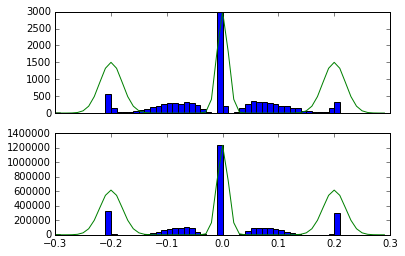

In [22]:
import numpy as np
from matplotlib import pyplot as plt


def NN_entropy_curve(W):
    px = dx/(sigma1*pisqrt) * (np.exp(-np.power(W, 2)/(2*sigma12))) +\
          dx/(sigma2*pisqrt) * (np.exp(-np.power(W - mu2, 2)/(2*sigma22))) +\
          dx/(sigma2*pisqrt) * (np.exp(-np.power(W + mu2, 2)/(2*sigma22)))
    return px
#    return -np.sum(px*np.log(px))

def plotW():
    x_ = np.arange(-0.3, 0.3, 0.01)
    f, axarr = plt.subplots(2, sharex=True)
    h1 = axarr[0].hist(sess.run(tf.reshape(W_fc2, [-1])), np.arange(-0.3,0.3,0.01))
    axarr[0].plot(x_, max(h1[0])*NN_entropy_curve(x_)/max(NN_entropy_curve(x_)))
    h2 = axarr[1].hist(sess.run(tf.reshape(W_fc1, [-1])), np.arange(-0.3,0.3,0.01))
    axarr[1].plot(x_, max(h2[0])*NN_entropy_curve(x_)/max(NN_entropy_curve(x_)))
    plt.show()

plotW()
